In [32]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.angle_encoding_script import angle_encoding
from utils.haar_noising_script import apply_haar_scrambling

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import os
import math

import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim_func

import pennylane as qml

/Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model


In [13]:
device = "mps" if torch.mps.is_available() else "cpu"
print(f"Using device: {device}")

filename = "data/QG1_64x64_1k"
data_X = np.array(h5py.File(filename, "r")['X'])
data_X = np.log1p(data_X.astype(np.float32))
data_X = data_X / data_X.max()
data_X = 2.0 * data_X - 1.0 # Range [-1, 1]

dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, interface="torch")
def pixel_circuit(inputs):
    thetas = (inputs + 1.0) * (np.pi / 2.0)
    
    qml.RY(thetas, wires=0)
    
    # Measure Z expectation
    return qml.expval(qml.PauliZ(0))

def embed_pixels_flat(images):
    N, H, W = images.shape

    # Flatten everything: (N * 64 * 64)
    flat_pixels = torch.tensor(images).view(-1)
        
    # Big batch size if circuit is small
    batch_size = 16384 
    results = []
    
    with torch.no_grad():
        for i in range(0, len(flat_pixels), batch_size):
            batch = flat_pixels[i : i + batch_size]
            q_out = pixel_circuit(batch)
            results.append(q_out)
            
    results = torch.cat(results, dim=0)
    
    q_images = results.reshape(N, 1, H, W)
    return q_images.float()

print(data_X[0])
quantum_data = embed_pixels_flat(data_X)
print(quantum_data[0])

print(f"Data Shape: {data_X.shape}")

Using device: mps
[[-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.       -1.       -1.       ... -0.989879 -1.       -1.      ]
 ...
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]]
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9999, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])
Data Shape: (1000, 64, 64)


In [14]:
class PixelDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Learnable inverse function
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 1) # Output 1 channel
        )
        
    def forward(self, x):
        return self.net(x)

decoder = PixelDecoder().to(device)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-3)
crit_dec = nn.MSELoss()

dset_dec = TensorDataset(quantum_data.to(device), torch.tensor(data_X).unsqueeze(1).to(device))
loader_dec = DataLoader(dset_dec, batch_size=64, shuffle=True)

for epoch in range(10):
    total_loss = 0
    for q, real in loader_dec:
        pred = decoder(q)
        loss = crit_dec(pred, real)
        opt_dec.zero_grad()
        loss.backward()
        opt_dec.step()
        total_loss += loss.item()
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: {total_loss/len(loader_dec):.6f}")

decoder.eval()

Epoch 0: 0.942388
Epoch 2: 0.285077
Epoch 4: 0.007307
Epoch 6: 0.000527
Epoch 8: 0.000019


PixelDecoder(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [15]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.lin = nn.Sequential(nn.Linear(dim, dim), nn.SiLU(), nn.Linear(dim, dim))
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=t.device) / half)
        args = t.unsqueeze(-1) * freqs.unsqueeze(0)
        return self.lin(torch.cat([torch.sin(args), torch.cos(args)], dim=-1))

class CoordUNet(nn.Module):
    def __init__(self, in_ch=4):
        super().__init__()
        self.time_emb = TimeEmbedding(64)
        
        # In: 4 quantum + 2 coord = 6
        self.inc = nn.Conv2d(in_ch + 2, 64, 3, padding=1)
        self.down1 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.SiLU())
        self.down2 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.SiLU())
        self.mid = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.SiLU())
        
        self.t_mlp1 = nn.Linear(64, 128)
        self.t_mlp2 = nn.Linear(64, 256)
        
        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.SiLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.SiLU())
        self.outc = nn.Conv2d(64, in_ch, 3, padding=1)

    def forward(self, x, t):
        B, C, H, W = x.shape
        # Add Coordinates
        yy, xx = torch.meshgrid(torch.linspace(-1,1,H,device=x.device), torch.linspace(-1,1,W,device=x.device), indexing='ij')
        x_in = torch.cat([x, yy.expand(B,1,H,W), xx.expand(B,1,H,W)], dim=1)
        
        t_emb = self.time_emb(t)
        x1 = F.silu(self.inc(x_in))
        x2 = self.down1(x1) + self.t_mlp1(t_emb)[...,None,None]
        x3 = self.down2(x2) + self.t_mlp2(t_emb)[...,None,None]
        mid = self.mid(x3)
        u1 = self.up1(mid)
        u1 = torch.cat([u1, x2], dim=1)
        u2 = self.up2(u1)
        return self.outc(u2 + x1)

In [22]:
class CoordUNet(nn.Module):
    def __init__(self, in_ch=1): # Changed to 1 channel
        super().__init__()
        self.time_emb = TimeEmbedding(64)
        
        # In: 1 quantum + 2 coord = 3
        self.inc = nn.Conv2d(in_ch + 2, 64, 3, padding=1)
        self.down1 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.SiLU())
        self.down2 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.SiLU())
        self.mid = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.SiLU())
        
        self.t_mlp1 = nn.Linear(64, 128)
        self.t_mlp2 = nn.Linear(64, 256)
        
        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.SiLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.SiLU())
        self.outc = nn.Conv2d(64, in_ch, 3, padding=1)

    def forward(self, x, t):
        B, C, H, W = x.shape
        yy, xx = torch.meshgrid(torch.linspace(-1,1,H,device=x.device), torch.linspace(-1,1,W,device=x.device), indexing='ij')
        x_in = torch.cat([x, yy.expand(B,1,H,W), xx.expand(B,1,H,W)], dim=1)
        
        t_emb = self.time_emb(t)
        x1 = F.silu(self.inc(x_in))
        x2 = self.down1(x1) + self.t_mlp1(t_emb)[...,None,None]
        x3 = self.down2(x2) + self.t_mlp2(t_emb)[...,None,None]
        mid = self.mid(x3)
        u1 = self.up1(mid)
        u1 = torch.cat([u1, x2], dim=1)
        u2 = self.up2(u1)
        return self.outc(u2 + x1)

# Training Loop
def robust_weighted_loss(pred, target, x1_data, weight_factor=10.0):
    # x1_data is now 1 channel. Signal is ~ -1. Background ~ +1.
    importance = (1.0 - x1_data) * 0.5
    weights = 1.0 + (weight_factor * importance)
    return ((pred - target)**2 * weights).mean()

model = CoordUNet(in_ch=1).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(TensorDataset(quantum_data.to(device)), batch_size=32, shuffle=True)

print("Training Pixel-Wise Flow Matching...")
losses = []
for epoch in range(1, 41):
    model.train()
    batch_loss = 0
    for (x1,) in loader:
        x0 = torch.randn_like(x1)
        t = torch.rand(x1.size(0), device=device)
        t_view = t.view(-1, 1, 1, 1)
        x_t = (1-t_view)*x0 + t_view*x1
        target_v = x1 - x0
        
        pred_v = model(x_t, t)
        loss = robust_weighted_loss(pred_v, target_v, x1)
        
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        batch_loss += loss.item()

    epoch_avg = batch_loss / len(loader)
    losses.append(epoch_avg)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {epoch_avg:.5f}")

Training Pixel-Wise Flow Matching...
Epoch 10: Loss 0.14866
Epoch 20: Loss 0.07462
Epoch 30: Loss 0.06443
Epoch 40: Loss 0.04138


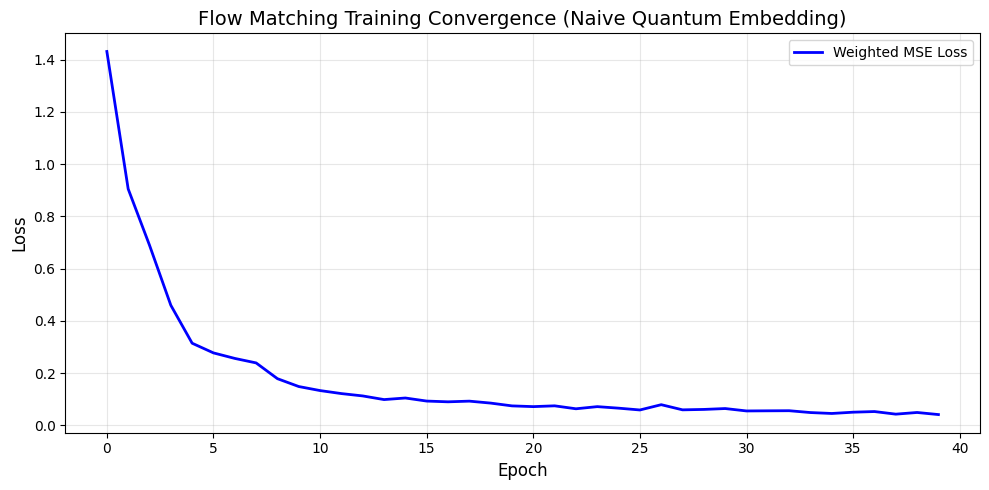

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Weighted MSE Loss', color='blue', linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Flow Matching Training Convergence (Naive Quantum Embedding)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

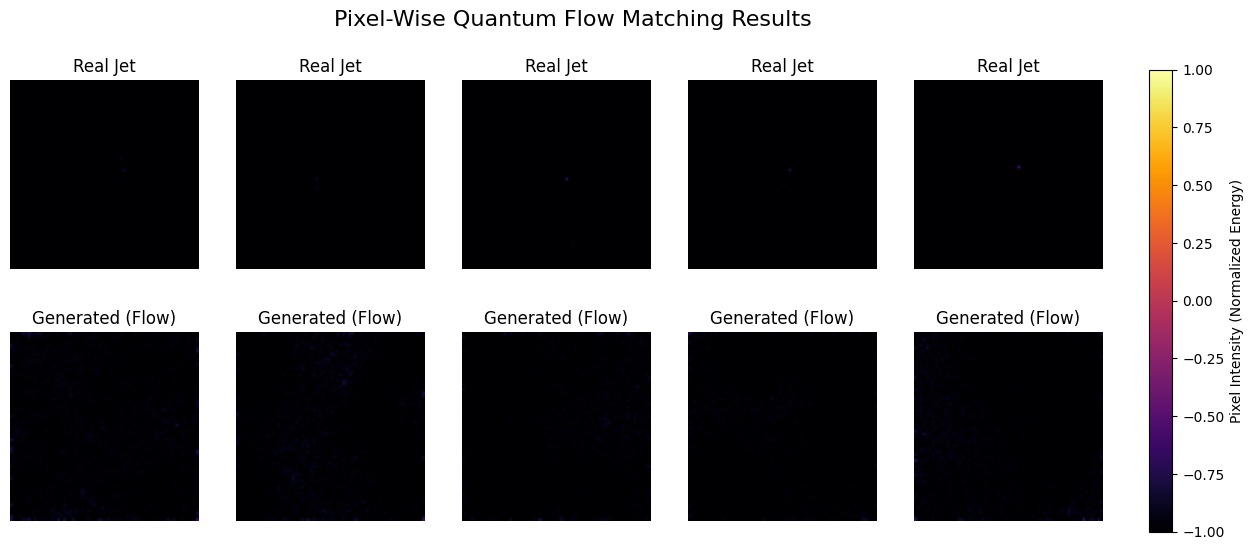

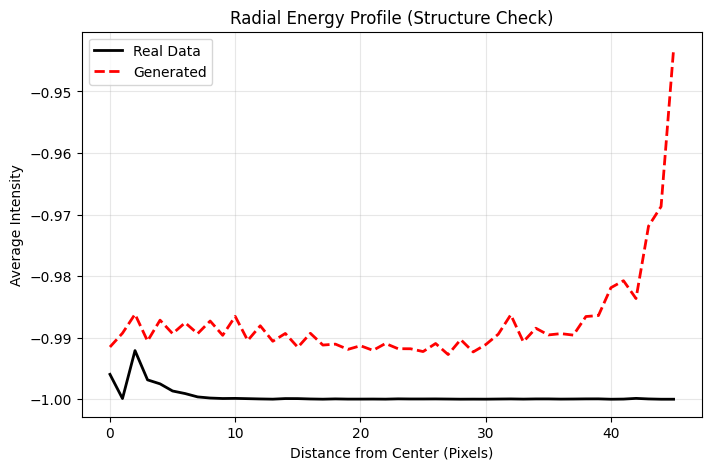

In [31]:
# %%
# [EVALUATION]

@torch.no_grad()
def sample_naive_flow(model, decoder, n_samples=10, steps=50):
    """
    Generates samples from the trained Flow Matching model.
    """
    model.eval()
    decoder.eval()
    
    # 1. Start from Gaussian Noise in the Quantum Latent Space
    # Shape: (N, 1, 64, 64) matches our Naive Embedding format
    x = torch.randn(n_samples, 1, 64, 64, device=device)
    
    # 2. Integrate ODE (Euler Method)
    # Evolve from t=0 (Noise) to t=1 (Data distribution)
    dt = 1.0 / steps
    
    for i in range(steps):
        t_val = i / steps
        t_batch = torch.full((n_samples,), t_val, device=device)
        
        # Predict velocity field v_t(x)
        v = model(x, t_batch)
        
        # Update state: x_{t+1} = x_t + v * dt
        x = x + v * dt
        
    # 3. Decode Quantum States -> Pixel Values
    # The decoder inverts the angle embedding (approx. arccos)
    images_raw = decoder(x)
    
    # 4. Zero-Suppression (Physics Cleaning)
    # Real jets are sparse. We threshold weak noise in the vacuum to -1.0.
    threshold = -1.0
    images_clean = torch.where(images_raw < threshold, torch.tensor(-1.0, device=device), images_raw)
    
    return images_clean.cpu().numpy()

fake_imgs = sample_naive_flow(model, decoder, n_samples=10)
real_imgs = data_X[:10] # Compare with first 10 real images
# print(real_imgs)
# print(fake_imgs)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
# Set consistent scale for physics comparison
vmin, vmax = -1.0, 1.0 

for i in range(5):
    im1 = axs[0, i].imshow(real_imgs[i].squeeze(), cmap='inferno', vmin=vmin, vmax=vmax)
    axs[0, i].set_title("Real Jet")
    axs[0, i].axis('off')
    
    im2 = axs[1, i].imshow(fake_imgs[i].squeeze(), cmap='inferno', vmin=vmin, vmax=vmax)
    axs[1, i].set_title("Generated (Flow)")
    axs[1, i].axis('off')

# Add a colorbar to the figure
cbar = fig.colorbar(im2, ax=axs.ravel().tolist(), fraction=0.02, pad=0.04)
cbar.set_label("Pixel Intensity (Normalized Energy)")
plt.suptitle("Pixel-Wise Quantum Flow Matching Results", fontsize=16)
plt.show()

# This checks if the model learned that jets are centered (the "Physics Check")
def get_radial_profile(imgs):
    # imgs shape: (N, H, W)
    N, H, W = imgs.shape
    Y, X = np.ogrid[:H, :W]
    center = (H//2, W//2)
    
    # Calculate distance from center for every pixel
    dist = np.sqrt((X - center[1])**2 + (Y - center[0])**2).astype(int)
    
    # Average intensity per radial bin
    tbin = np.bincount(dist.ravel(), imgs.reshape(N, -1).mean(0))
    nr = np.bincount(dist.ravel())
    
    # Handle division by zero for corners
    radial_profile = tbin / np.maximum(nr, 1)
    return radial_profile

rad_real = get_radial_profile(real_imgs.squeeze())
rad_fake = get_radial_profile(fake_imgs.squeeze())

plt.figure(figsize=(8, 5))
plt.plot(rad_real, label='Real Data', color='black', linewidth=2)
plt.plot(rad_fake, label='Generated', color='red', linestyle='--', linewidth=2)
plt.xlabel("Distance from Center (Pixels)")
plt.ylabel("Average Intensity")
plt.title("Radial Energy Profile (Structure Check)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Retraining with Aggressive Weights (Factor=200)...
Epoch 10: Loss 0.17544
Epoch 20: Loss 0.10389
Epoch 30: Loss 0.06813
Epoch 40: Loss 0.05720
Epoch 50: Loss 0.04425
Epoch 60: Loss 0.04991


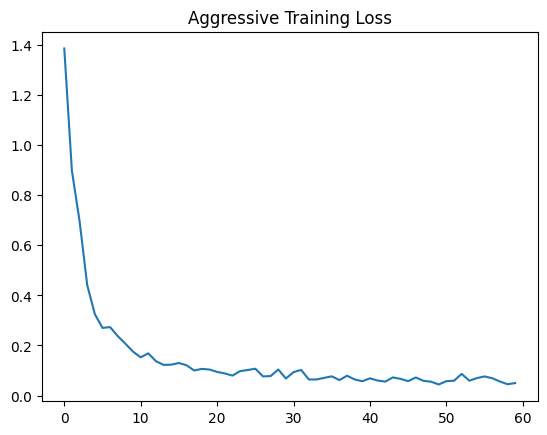

In [30]:
def aggressive_weighted_loss(pred, target, x1_data, weight_factor=200.0):
    """
    x1_data: Real Data. Background ~ +1.0, Signal < +1.0
    
    We want to punish errors on the Signal pixels massively.
    """
    # Background (1.0) -> 0.0
    # Signal (0.99) -> 0.01
    is_signal = (1.0 - x1_data)
    
    # Base weight is 1.0 (for background)
    # Signal weight adds 200 * deviation
    # Example: A pixel with value 0.9 (strong signal) gets weight 1 + 200*0.1 = 21.0
    weights = 1.0 + (weight_factor * is_signal)
    
    diff = (pred - target) ** 2
    return (diff * weights).mean()

# Re-initialize to start fresh
model = CoordUNet(in_ch=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(TensorDataset(quantum_data.to(device)), batch_size=32, shuffle=True)

print("Retraining with Aggressive Weights (Factor=200)...")
losses = []

for epoch in range(1, 61):
    model.train()
    batch_loss = 0.0
    
    for (x1,) in train_loader:
        # Standard Flow Matching Steps
        x0 = torch.randn_like(x1)
        t = torch.rand(x1.size(0), device=device)
        t_view = t.view(-1, 1, 1, 1)
        x_t = (1 - t_view) * x0 + t_view * x1
        target_v = x1 - x0
        
        pred_v = model(x_t, t)
        
        # USE NEW LOSS
        loss = aggressive_weighted_loss(pred_v, target_v, x1_data=x1, weight_factor=200.0)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        batch_loss += loss.item()
        
    avg = batch_loss / len(train_loader)
    losses.append(avg)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {avg:.5f}")

plt.plot(losses)
plt.title("Aggressive Training Loss")
plt.show()